## 设计基函数(basis function) 以及数据读取

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def identity_basis(x):
    ret = np.expand_dims(x, axis=1)
    return ret

def multinomial_basis(x, feature_num=10):
    x = np.expand_dims(x, axis=1) # shape(N, 1)
    feat = [x]
    for i in range(2, feature_num+1):
        feat.append(x**i)
    ret = np.concatenate(feat, axis=1)
    return ret

def gaussian_basis(x, feature_num=10):
    centers = np.linspace(0, 25, feature_num)
    width = 1.0 * (centers[1] - centers[0])
    x = np.expand_dims(x, axis=1)
    x = np.concatenate([x]*feature_num, axis=1)

    out = (x-centers)/width
    ret = np.exp(-0.5 * out ** 2)
    return ret

def load_data(filename, basis_func=gaussian_basis):
    """载入数据。"""
    xys = []
    with open(filename, 'r') as f:
        for line in f:
            xys.append(map(float, line.strip().split()))
        xs, ys = zip(*xys)
        xs, ys = np.asarray(xs), np.asarray(ys)

        o_x, o_y = xs, ys
        phi0 = np.expand_dims(np.ones_like(xs), axis=1)
        phi1 = basis_func(xs)
        xs = np.concatenate([phi0, phi1], axis=1)
        return (np.float32(xs), np.float32(ys)), (o_x, o_y)

## 定义模型

In [26]:
import tensorflow as tf
from tensorflow.keras import optimizers, layers, Model

class linearModel(Model):
    def __init__(self, ndim):
        super(linearModel, self).__init__()
        self.w = tf.Variable(
            shape=[ndim, 1],
            initial_value=tf.random.uniform(
                [ndim,1], minval=-0.1, maxval=0.1, dtype=tf.float32))

    @tf.function
    def call(self, x):
        y = tf.squeeze(tf.matmul(x, self.w), axis=1)
        return y

(xs, ys), (o_x, o_y) = load_data('./Data/train.txt')
ndim = xs.shape[1]

model = linearModel(ndim=ndim)


## 训练以及评估

In [27]:
optimizer = optimizers.Adam(0.1)
@tf.function
def train_one_step(model, xs, ys):
    with tf.GradientTape() as tape:
        y_preds = model(xs)
        loss = tf.reduce_mean(tf.sqrt(1e-12+(ys-y_preds)**2))
    grads = tape.gradient(loss, model.w)
    optimizer.apply_gradients([(grads, model.w)])
    return loss

@tf.function
def predict(model, xs):
    y_preds = model(xs)
    return y_preds

def evaluate(ys, ys_pred):
    """评估模型。"""
    std = np.sqrt(np.mean(np.abs(ys - ys_pred) ** 2))
    return std

loss is 11.86
loss is 1.279
loss is 0.7912
loss is 0.3427
loss is 0.2939
loss is 0.2884
loss is 0.288
loss is 0.2878
loss is 0.2875
loss is 0.2875
loss is 0.2876
loss is 0.2872
loss is 0.2871
loss is 0.2865
loss is 0.2866
loss is 0.2863
loss is 0.2863
loss is 0.286
loss is 0.286
loss is 0.2857
训练集预测值与真实值的标准差：0.5
训练集预测值与真实值的标准差：0.7


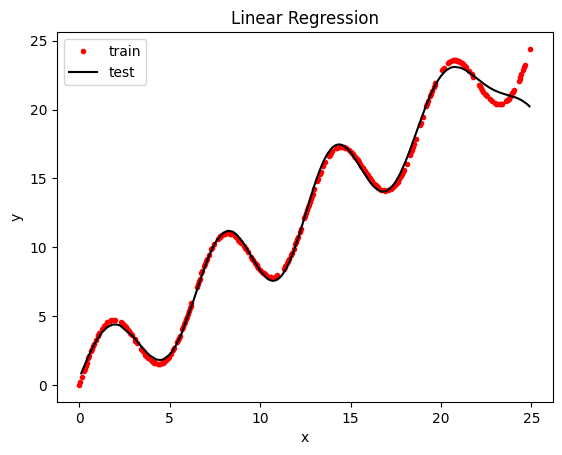

In [28]:
for i in range(20000):
    loss = train_one_step(model, xs, ys)
    if i % 1000 == 1:
        print(f'loss is {loss:.4}')


y_preds = predict(model, xs)
std = evaluate(ys, y_preds)
print('训练集预测值与真实值的标准差：{:.1f}'.format(std))

(xs_test, ys_test), (o_x_test, o_y_test) = load_data('./Data/test.txt')

y_test_preds = predict(model, xs_test)
std = evaluate(ys_test, y_test_preds)
print('训练集预测值与真实值的标准差：{:.1f}'.format(std))

plt.plot(o_x, o_y, 'ro', markersize=3)
plt.plot(o_x_test, y_test_preds, 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend(['train', 'test', 'pred'])
plt.show()


## 梯度下降法

step 1, loss: 0.9024
step 1001, loss: 0.0331
step 2001, loss: 0.01179
step 3001, loss: 0.003722
step 4001, loss: 0.002672
step 5001, loss: 0.002641
step 6001, loss: 0.002639
step 7001, loss: 0.002639
step 8001, loss: 0.002638
step 9001, loss: 0.00264
step 10001, loss: 0.002643
step 11001, loss: 0.002639
step 12001, loss: 0.002655
step 13001, loss: 0.002638
step 14001, loss: 0.002639
step 15001, loss: 0.002638
step 16001, loss: 0.002638
step 17001, loss: 0.002638
step 18001, loss: 0.002679
step 19001, loss: 0.002638
训练集预测值与真实值的标准差：0.4
测试集预测值与真实值的标准差：0.4


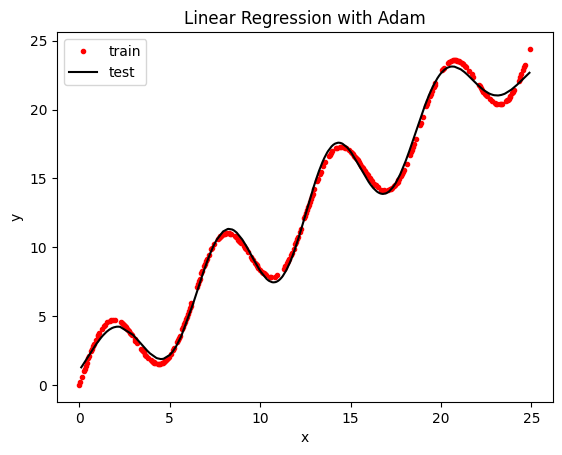

In [29]:
class LinearRegressionGD(tf.keras.Model):
    def __init__(self, ndim):
        super(LinearRegressionGD, self).__init__()
        self.w = tf.Variable(
            initial_value=tf.random.uniform(
                [ndim, 1], minval=-0.01, maxval=0.01, dtype=tf.float32),
            trainable=True)

    @tf.function
    def call(self, x):
        y = tf.squeeze(tf.matmul(x, self.w), axis=1)
        return y

# 加载数据并进行标准化
(xs, ys), (o_x, o_y) = load_data('./Data/train.txt')
ndim = xs.shape[1]

# 对特征进行标准化
xs_mean = tf.reduce_mean(xs, axis=0)
xs_std = tf.math.reduce_std(xs, axis=0)
xs = (xs - xs_mean) / (xs_std + 1e-8)

# 对标签进行标准化
ys_mean = tf.reduce_mean(ys)
ys_std = tf.math.reduce_std(ys)
ys = (ys - ys_mean) / ys_std

model = LinearRegressionGD(ndim=ndim)
optimizer = optimizers.Adam(learning_rate=0.01)

@tf.function
def train_one_step(model, optimizer, xs, ys):
    with tf.GradientTape() as tape:
        y_preds = model(xs)
        loss = tf.reduce_mean((ys - y_preds)**2)

    # 正确获取梯度和变量
    grads = tape.gradient(loss, [model.w])
    optimizer.apply_gradients(zip(grads, [model.w]))

    return loss

# 训练模型
for i in range(20000):
    loss = train_one_step(model, optimizer, xs, ys)
    if i % 1000 == 1:
        print(f'step {i}, loss: {loss:.4}')

# 评估训练集
y_preds = predict(model, xs)
# 反标准化预测结果
y_preds = y_preds * ys_std + ys_mean
std = evaluate(o_y, y_preds)
print('训练集预测值与真实值的标准差：{:.1f}'.format(std))

# 测试集评估
(xs_test, ys_test), (o_x_test, o_y_test) = load_data('./Data/test.txt')
# 对测试集进行相同的标准化
xs_test = (xs_test - xs_mean) / (xs_std + 1e-8)
# 预测并反标准化
y_test_preds = predict(model, xs_test)
y_test_preds = y_test_preds * ys_std + ys_mean
std = evaluate(ys_test, y_test_preds)
print('测试集预测值与真实值的标准差：{:.1f}'.format(std))

# 绘制结果
plt.plot(o_x, o_y, 'ro', markersize=3)
plt.plot(o_x_test, y_test_preds, 'k')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression with Adam')
plt.legend(['train', 'test', 'pred'])
plt.show()